In [2]:
import pandas as pd

df = pd.read_csv('data/sanity_report.tsv', sep='\t')
#mask = (df["PAINS"].values == "NO") & (df["REACTIVE_GROUPS"].values == "NONE") & (df["AGGREGATOR_FLAGS"].values == "NONE")

clean_molecules = df[["SMILES", "ZINC_ID"]].drop_duplicates()
print(clean_molecules.shape)

(9133912, 2)


In [3]:
print(clean_molecules["ZINC_ID"].nunique())
print(clean_molecules["SMILES"].nunique())

9133912
9131118


In [5]:
unique_smiles_df = clean_molecules.drop_duplicates(subset="SMILES")
print(unique_smiles_df.shape)
unique_smiles_df.head()

(9131118, 2)


,SMILES,ZINC_ID
0,C[S@@](=O)CC(N)=O,34310585
1,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,4371221
2,NCc1cc(=O)[nH]c(O)n1,26507110
3,CS(=O)(=O)CCCNN,63014624
4,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,242677143


In [6]:
print(unique_smiles_df["ZINC_ID"].nunique())
print(unique_smiles_df["SMILES"].nunique())

9131118
9131118


In [7]:
SAMPLE_SIZE = 200

df_sample = unique_smiles_df.sample(n=SAMPLE_SIZE, random_state=42)

df_sample.reset_index(drop=True, inplace=True)

In [8]:
#df_sample = df_sample.head(100000)
df_sample.to_csv("data/sample_2k_library.csv", index=False)

In [7]:
from rdkit import Chem

def smiles_to_mol(s):
    return Chem.MolFromSmiles(s)

df_sample_mol = df_sample["SMILES"].apply(smiles_to_mol).to_frame(name="Mol")

KeyboardInterrupt: 

In [9]:
df_sample_mol.isna().any()

Mol    False
dtype: bool

In [10]:
df_sample_mol.head()

,Mol
0,<rdkit.Chem.rdchem.Mol object at 0x1d4ec9af0>
1,<rdkit.Chem.rdchem.Mol object at 0x1d4ec9d20>
2,<rdkit.Chem.rdchem.Mol object at 0x1d4ec9d90>
3,<rdkit.Chem.rdchem.Mol object at 0x1d4ec9230>
4,<rdkit.Chem.rdchem.Mol object at 0x1d4ec9e00>


In [24]:
from rdkit.Chem import rdMolDescriptors, Crippen, Lipinski, QED

df_sample_mol["MW"] = df_sample_mol["Mol"].apply(rdMolDescriptors.CalcExactMolWt)
df_sample_mol["LogP"] = df_sample_mol["Mol"].apply(Crippen.MolLogP)
df_sample_mol["TPSA"] = df_sample_mol["Mol"].apply(rdMolDescriptors.CalcTPSA)
df_sample_mol["HBD"] = df_sample_mol["Mol"].apply(Lipinski.NumHDonors)
df_sample_mol["HBA"] = df_sample_mol["Mol"].apply(Lipinski.NumHAcceptors)
df_sample_mol["QED"] = df_sample_mol["Mol"].apply(QED.qed)

df_sample_mol["HBD_HBA"] = df_sample_mol["HBD"] + df_sample_mol["HBA"]


In [29]:
# Compute descriptors for scaffold diversity
df_sample_mol["FractionCsp3"] = df_sample_mol["Mol"].apply(rdMolDescriptors.CalcFractionCSP3)
df_sample_mol["NumAromaticRings"] = df_sample_mol["Mol"].apply(Lipinski.NumAromaticRings)

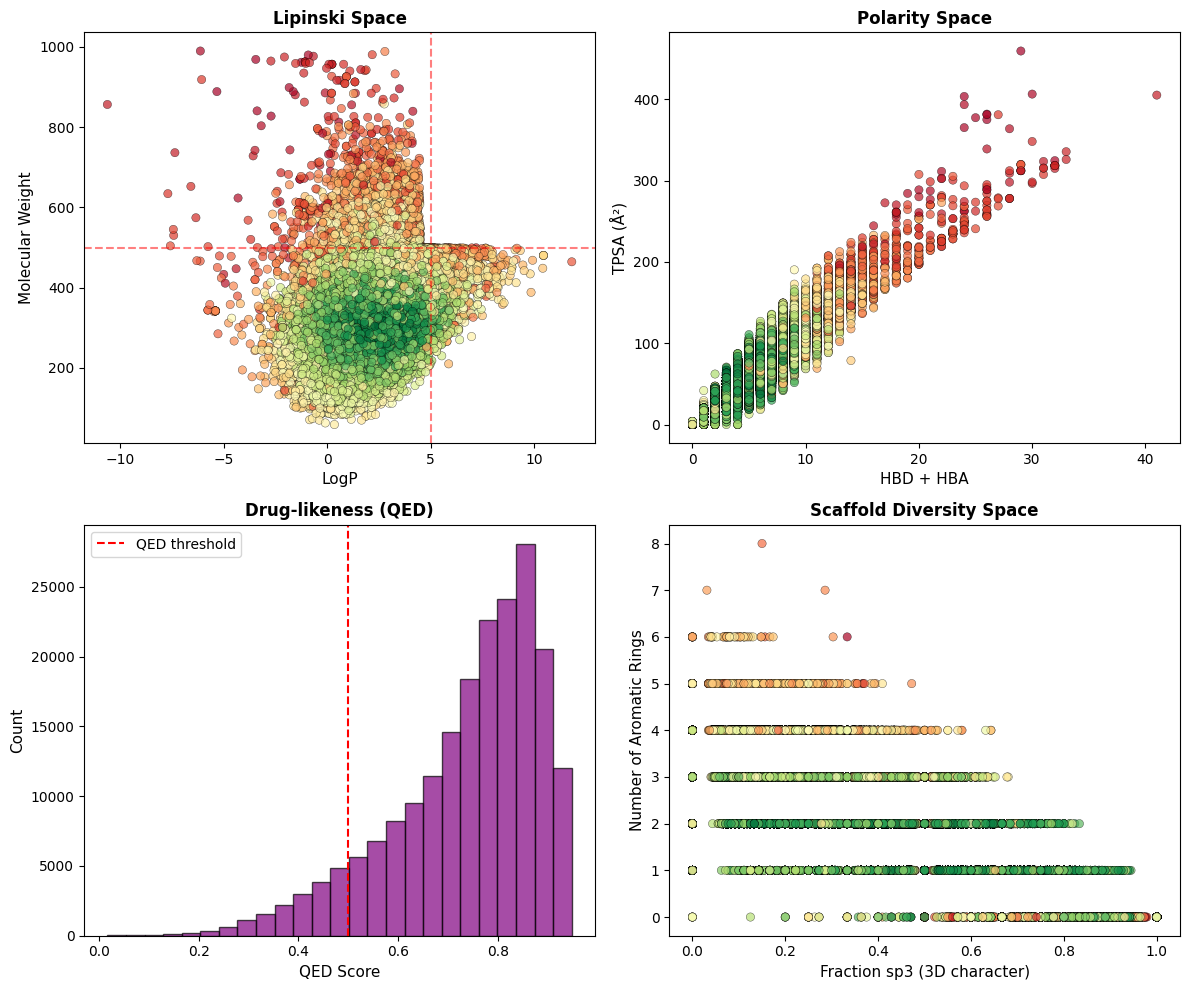

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ============================================================
# CHEMICAL SPACE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MW vs LogP (Lipinski space)
ax1 = axes[0, 0]
scatter = ax1.scatter(df_sample_mol['LogP'], df_sample_mol['MW'],
                      c=df_sample_mol['QED'],
                      cmap='RdYlGn',
                      alpha=0.7, edgecolor='k', linewidth=0.3)
ax1.axhline(y=500, color='red', linestyle='--', alpha=0.5, label='Lipinski MW')
ax1.axvline(x=5, color='red', linestyle='--', alpha=0.5, label='Lipinski LogP')
ax1.set_xlabel('LogP', fontsize=11)
ax1.set_ylabel('Molecular Weight', fontsize=11)
ax1.set_title('Lipinski Space', fontsize=12, fontweight='bold')

# TPSA vs HBD+HBA
ax2 = axes[0, 1]
df_sample_mol['HB_total'] = df_sample_mol['HBD'] + df_sample_mol['HBA']
scatter2 = ax2.scatter(df_sample_mol['HB_total'], df_sample_mol['TPSA'],
                        cmap='RdYlGn',
                        c=df_sample_mol['QED'],
                       alpha=0.7, edgecolor='k', linewidth=0.3)
ax2.set_xlabel('HBD + HBA', fontsize=11)
ax2.set_ylabel('TPSA (Å²)', fontsize=11)
ax2.set_title('Polarity Space', fontsize=12, fontweight='bold')

# QED distribution
ax3 = axes[1, 0]
ax3.hist(df_sample_mol['QED'], bins=25, edgecolor='black', alpha=0.7, color='purple')
ax3.axvline(x=0.5, color='red', linestyle='--', label='QED threshold')
ax3.set_xlabel('QED Score', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Drug-likeness (QED)', fontsize=12, fontweight='bold')
ax3.legend()

ax4 = axes[1, 1]  # e.g., bottom-right panel

scatter = ax4.scatter(df_sample_mol['FractionCsp3'],
                      df_sample_mol['NumAromaticRings'],
                      c=df_sample_mol['QED'],
                      cmap='RdYlGn',
                      alpha=0.7, edgecolor='k', linewidth=0.3)

ax4.set_xlabel('Fraction sp3 (3D character)', fontsize=11)
ax4.set_ylabel('Number of Aromatic Rings', fontsize=11)
ax4.set_title('Scaffold Diversity Space', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/chemical_space.png', dpi=300, bbox_inches='tight')
plt.show()